In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, time, glob
import pyccl as ccl
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import abundance as cl_count
import covariance as covar
import mvp_pdf
import edit
import utils
import lnlikelihood as l
import importance_sampling as imp_samp
#sys.path.append('../modules/pinocchio_analysis/')
#import compute_mean_covariance_importance_sampling as Oms8
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_z_bin=4
n_m_bin=4

# Binned cluster abundance for the 1000 Pinocchio simualtions

$$
p(\vec{\theta}) = \mathcal{L}(\vec{\widehat{N}}|\vec{N}(\vec{\theta}))\ \pi(\vec{\theta})
$$

## pre-tabulated abundance $\vec{N}(\vec{\theta})$ and $q(\vec{\theta})$ on random position $\vec{\theta} \sim q$

In [3]:
ratio_f_sky = 1
where_tab=f'/sps/lsst/users/cpayerne/1000xsimulations/analysis/'
key = f'{n_z_bin}zx{n_m_bin}m/tabulated_model/4x4_sampled_abundance_from_'
where = where_tab+key+'*'
Nth, Om, s8, q_val=[],[],[],[]
for f in glob.glob(where):
    sampled_model=np.array(edit.load_hdf5(f))
    q=sampled_model['q']
    Nth.extend(ratio_f_sky * sampled_model['abundance'])
    q_val.extend(list(sampled_model['q']))
    Om.extend(list(sampled_model['Om']))
    s8.extend(list(sampled_model['s8']))

## Evaluationg posterior $p(\vec{\theta}|\vec{\widehat{N}})$ at the $\vec{\theta} \sim q$ random positions & compute weights  $w = p/q$

$$
p(\vec{\theta}) = \mathcal{L}(\vec{\widehat{N}}|\vec{N}(\vec{\theta}))\ \pi(\vec{\theta})
$$

In [4]:
lnL=l.lnLikelihood(theory=None)

In [5]:
lnL.lnLikelihood_Binned_Poissonian(np.array([[1, 2], [3, 5]]), np.array([[1, 2], [3, 5]]))

1.7293207892947213

In [6]:
likelihood='Poissonian'
def lnposterior(model, data):
    #define the posterior
    return lnL.lnPosterior(model, data, likelihood=likelihood)

In [7]:
label = ''
dat = edit.load_pickle(f'/sps/lsst/users/cpayerne/1000xsimulations/analysis/binned_catalogs/{n_z_bin}x{n_m_bin}_binned_catalogs.pkl')
#dat = edit.load_pickle(f'/sps/lsst/users/cpayerne/1000xsimulations/analysis/binned_catalogs/{n_z_bin}x{n_m_bin}_binned_catalogs_sup_5e14Msun.pkl')
#dat = edit.load_pickle(f'/sps/lsst/users/cpayerne/1000xsimulations/analysis/binned_catalogs/{n_z_bin}x{n_m_bin}_binned_catalogs.pkl')
Nobs = np.array(dat[3])

In [8]:
Nobs[20]

array([[1.7895e+04, 4.0220e+03, 5.4600e+02, 2.9000e+01],
       [2.6428e+04, 4.5600e+03, 4.0600e+02, 1.5000e+01],
       [2.2426e+04, 2.9830e+03, 1.8100e+02, 1.0000e+00],
       [1.4060e+04, 1.2740e+03, 4.3000e+01, 0.0000e+00]])

In [9]:
index_simu= 20
def compute_weights(n, mp=False):
    res=np.array([lnposterior(model, Nobs[n]) for model in Nth])
    res=res-np.min(res)
    w=np.exp(res)/q_val
    w=w/np.max(w)
    return w

In [10]:
weights = compute_weights(index_simu, mp=False)

In [11]:
weights

array([5.15606702e-02, 4.48090105e-19, 2.19760641e-05, ...,
       3.69009441e-08, 1.62554267e-17, 2.82993876e-05])

In [12]:
#weights = np.array(utils.map(compute_weights, np.arange(n_test), ncores=8, ordered=True, progress=True))

In [13]:
mcmc = np.load(f'/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/notebooks/Unbinned_likelihood_with_SSC/manuscript/noSSC_full_binned_testing_likelihood_accuracy.npy')

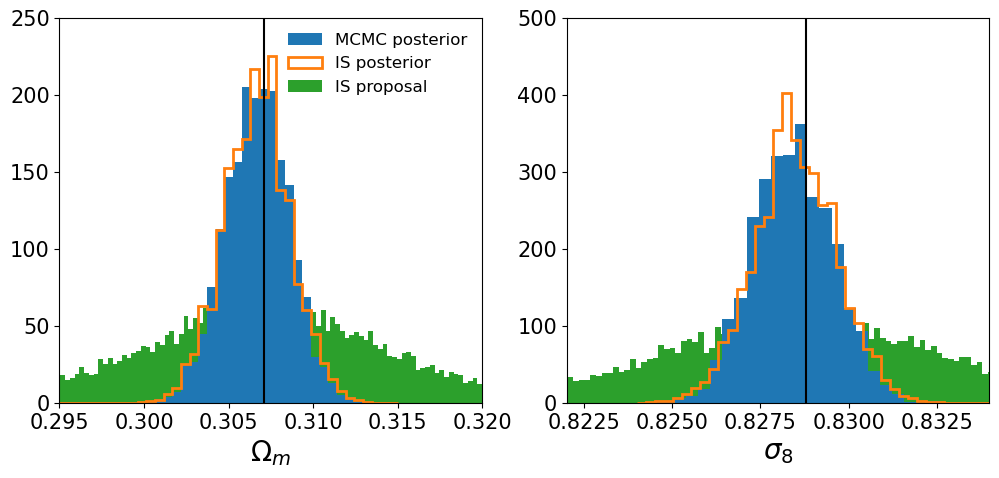

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
n = 7000
ax[0].hist(mcmc[:,0][5000:15000:3], density = True, bins = np.linspace(0.295, 0.315, 40), label='MCMC posterior')
ax[0].hist(Om, weights=weights, density = True, bins =  np.linspace(0.295, 0.315, 40), histtype = 'step', linewidth=2, label = 'IS posterior')
ax[0].hist(Om, density = True, zorder=0, bins = 100, label='IS proposal')
ax[0].set_xlim(0.295, 0.32)
ax[0].set_xlabel(r'$\Omega_m$', fontsize=20)
ax[0].tick_params(axis='both', which="both", labelsize= 15)
ax[0].legend(fontsize=12, frameon=False)
ax[0].vlines(Omega_c_true + Omega_b_true, 0, 250, ls='-', color='k')
ax[0].set_ylim(0, 250)
ax[1].hist(mcmc[:,1][5000:15000:3], density = True, bins = np.linspace(0.824, 0.834, 30))
ax[1].hist(s8, weights=weights, density = True, bins = np.linspace(0.824, 0.834, 40), histtype = 'step',linewidth=2)
ax[1].hist(s8, density = True, zorder=0, bins = 100)
ax[1].set_xlim(0.822, 0.834)
ax[1].set_xlabel(r'$\sigma_8$', fontsize=20)
ax[1].tick_params(axis='both', which="both", labelsize= 15)
ax[1].vlines(sigma8_true, 0, 500, ls='-', color='k')
ax[1].set_ylim(0, 500)
plt.savefig('importance_sampling_cluster_count_vs_mcmc.png', bbox_inches='tight', dpi=300)